# Federated Semantic Segmentation for Self Driving Cars

## STEP 0: SETUP PHASE

### Installs

In [1]:
!pip install torchmetrics
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 22.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=a6cec2bf64cc1cc4187d22b1d09b11ad97ac9db58d6d702e95928ee284ea604b
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


### Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/AMLproject/

/content/drive/MyDrive/AMLproject


### Cloning FedDrive

In [4]:
import os
if not os.path.isdir('./FedDrive'):
  !git clone https://github.com/Erosinho13/FedDrive


### Imports

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
import numpy as np
import matplotlib.pyplot as plt
import random
# import torchvision
# import logging
import warnings
import math
import json
import wandb

# from torchvision import transforms
from torch.backends import cudnn
from torch import from_numpy
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.io import read_image # importare solo se si usa nella classe Dataset
from torchmetrics.classification import MulticlassJaccardIndex
from torchvision.datasets import VisionDataset

from drive.MyDrive.AMLproject import transform as T
from FedDrive.src.modules.bisenetv2 import BiSeNetV2

warnings.resetwarnings()
warnings.simplefilter('ignore')


### Parameter Configuration Step 2

In [6]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

PARTITION = 'A' # A or B to choose which dataloader to use
SEED = 42
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 19
if NUM_CLASSES == 19:
  cl19 = True

BATCH_SIZE = 8     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing ***
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05           # The initial Learning Rate ***
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD ***
WEIGHT_DECAY =0.0005  # Regularization, you can keep this at the default ***

NUM_EPOCHS = 10     # Total number of training epochs (iterations over dataset)

# servono per decrementare il lerning rate nel tempo 
# STEP_SIZE = 500       # How many epochs before decreasing learning rate (if using a step-down policy)
# GAMMA = 0.8          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 20
LOG_FREQUENCY_EPOCH = 3

ROOT_DIR = os.path.join('data', 'Cityscapes')
ROOT_DIR_GTA5 = os.path.join('data', 'GTA5')


### Parameter configuration Step 3

In [8]:
PARTITION = "B"  # 'A' or 'B'
SPLIT = 1  # 1 or 2 // 1 = Uniform : 2 = Heterogenous
MAX_SAMPLE_PER_CLIENT = 20

IMAGES_FINAL = "leftImg8bit"
TARGET_FINAL = "gtFine_labelIds"

N_ROUND = 50
CLIENT_PER_ROUND = 5  # clients picked each round
NUM_EPOCHS = 2


CHECKPOINTS = 5


if PARTITION == 'A':
  if SPLIT == 1:
    TOT_CLIENTS = 36
  else:
    TOT_CLIENTS = 46
else:
  if SPLIT == 1:
    TOT_CLIENTS = 25
  else:
    TOT_CLIENTS = 33


### Parameter configuration Step 4.2

In [120]:
PARTITION = 'A' # A or B to choose which dataloader to use
SEED = 42
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 19
cl19 = True

BATCH_SIZE = 5     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing ***
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05           # The initial Learning Rate ***
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD ***
WEIGHT_DECAY =0.0005  # Regularization, you can keep this at the default ***

NUM_EPOCHS = 10     # Total number of training epochs (iterations over dataset)

# servono per decrementare il lerning rate nel tempo 
# STEP_SIZE = 500       # How many epochs before decreasing learning rate (if using a step-down policy)
# GAMMA = 0.8          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 20
LOG_FREQUENCY_EPOCH = 3


LOAD_CKPT_PATH = 'ckpt_0.pth'
CKPT_PATH = './checkpoints/'
CKPT_DIR = './checkpoints/'
LOAD_CKPT = False

CTSC_ROOT = "./data/Cityscapes/"
GTA5_ROOT = "./data/GTA5/"


### Data Augmentation Options

In [119]:
# data augmentation options
# set as None if a transformation should not be used

RANDOM_HORIZONTAL_FLIP = 0.5
#RANDOM_HORIZONTAL_FLIP = None      #probability of the image being flipped
COLOR_JITTER = (0.2,0.3,0.2,0.2) # (brighteness, contrast, saturation, hue)
#COLOR_JITTER = None
RANDOM_ROTATION = 5              # degree of rotation
#RANDOM_ROTATION = None
#RANDOM_CROP = (512,1024)         # output size of the crop
RANDOM_CROP = None
RESIZE = (512,1024)              # output size
#RESIZE = None
RANDOM_VERTICAL_FLIP  = 0.3     # probability of the image being flipped
#RANDOM_VERTICAL_FLIP = None
CENTRAL_CROP = (512,1024)
#CENTRAL_CROP = (512,1024)
#RANDOM_RESIZE_CROP = (1024,2048)
RANDOM_RESIZE_CROP = None

### Transforms setup

In [92]:
def setup_transform():
    transformers = []
    if RANDOM_HORIZONTAL_FLIP is not None:
        transformers.append(T.RandomHorizontalFlip(RANDOM_HORIZONTAL_FLIP))
    if COLOR_JITTER is not None:
        transformers.append(T.ColorJitter(*COLOR_JITTER))
    if RANDOM_ROTATION is not None:
        transformers.append(T.RandomRotation(RANDOM_ROTATION))
    if RANDOM_CROP is not None:
        transformers.append(T.RandomCrop(RANDOM_CROP))
    if RANDOM_VERTICAL_FLIP is not None:
        transformers.append(T.RandomVerticalFlip(RANDOM_VERTICAL_FLIP))
    if CENTRAL_CROP is not None:
        transformers.append(T.CenterCrop(CENTRAL_CROP))
    if RANDOM_RESIZE_CROP is not None:
        transformers.append(T.RandomResizedCrop(RANDOM_RESIZE_CROP))
    if RESIZE is not None:
        transformers.append(T.Resize(RESIZE))

    transformers.append(T.ToTensor())

    transforms = T.Compose(transformers)

    return transforms

### Fixing random seed

In [121]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

### Datsets

#### Cityscapes

In [12]:
class Cityscapes(torch_data.Dataset):

    """
    image path: data/Cityscapes/images/name_leftImg8bit.png
    taget path: data/Cityscapes/labels/name_gtFine_labelIds.png
    """

    def __init__(self, root, transform=None, cl19=False, filename=None, id_client=None):
        eval_classes = [
            7,
            8,
            11,
            12,
            13,
            17,
            19,
            20,
            21,
            22,
            23,
            24,
            25,
            26,
            27,
            28,
            31,
            32,
            33,
        ]
        self.root = root

        if filename is None:
            raise ValueError("filename is None")

        if id_client is not None:
            with open(os.path.join(root, filename)) as f:
                dict_data = json.load(f)

            self.paths_images = [l[0] for l in dict_data[str(id_client)]]
            self.paths_tagets = [l[1] for l in dict_data[str(id_client)]]

        else:
            with open(os.path.join(root, filename), "r") as f:
                lines = f.readlines()

            # manipulate each file row in order to obtain the correct path
            self.paths_images = [l.strip().split("@")[0] for l in lines]
            self.paths_tagets = [l.strip().split("@")[1] for l in lines]

            # self.len = len(self.paths_images)
            # self.transform = transform

        self.len = len(self.paths_images)
        self.transform = transform
        self.return_unprocessed_image = False

        if cl19:
            classes = eval_classes
            mapping = np.zeros((256,), dtype=np.int64) + 255
            for i, cl in enumerate(classes):
                mapping[cl] = i
            self.target_transform = lambda x: from_numpy(mapping[x])

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is the label of segmentation.
        """

        # # using read_image
        # img = read_image(os.path.join(self.root, "images", self.paths_images[index]))
        # target = read_image(os.path.join(self.root, "labels", self.paths_tagets[index]))

        # # using PIL
        img = Image.open(os.path.join(self.root,"images",self.paths_images[index]))
        target = Image.open(os.path.join(self.root,"labels",self.paths_tagets[index]))

        if self.return_unprocessed_image:
            # transform_PIL = T.ToPILImage()
            # img = transform_PIL(img)
            return img

        if self.transform:
            img, target = self.transform(img, target)

        if self.target_transform:
            target = self.target_transform(target)

        return img, target  # output: Tensor[image_channels, image_height, image_width]

        # # using Image.open + np.array
        

        # return np.array(img), np.array(target) # output: Tensor[image_height, image_width, image_channels]

    def __len__(self):
        return self.len


#### GTA5

In [13]:
class GTA5(VisionDataset):
    labels2train = {
        "cityscapes": {
            7: 0,
            8: 1,
            11: 2,
            12: 3,
            13: 4,
            17: 5,
            19: 6,
            20: 7,
            21: 8,
            22: 9,
            23: 10,
            24: 11,
            25: 12,
            26: 13,
            27: 14,
            28: 15,
            31: 16,
            32: 17,
            33: 18,
        },
    }

    def __init__(
        self,
        root,
        transform=None,
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
        cv2=False,
        target_dataset="cityscapes",
    ):
        assert (
            target_dataset in GTA5.labels2train
        ), f"Class mapping missing for {target_dataset}, choose from: {GTA5.labels2train.keys()}"

        self.labels2train = GTA5.labels2train[target_dataset]

        # super().__init__(root, transform=transform, target_transform=None)

        self.root = root
        self.transform = transform
        self.mean = mean
        self.std = std
        self.cv2 = cv2

        self.target_transform = self.__map_labels()

        self.return_unprocessed_image = False
        self.style_tf_fn = None

        with open(os.path.join(self.root, "train.txt"), "r") as f:
            lines = f.readlines()

        # manipulate each file row in order to obtain the correct path
        self.paths_images = [l.strip() for l in lines]
        # self.paths_tagets = [l for l in lines]

        self.len = len(self.paths_images)

    def set_style_tf_fn(self, style_tf_fn):
        self.style_tf_fn = style_tf_fn

    def reset_style_tf_fn(self):
        self.style_tf_fn = None

    def __getitem__(self, index):
        x_path = os.path.join(self.root, "images", self.paths_images[index])
        y_path = os.path.join(self.root, "labels", self.paths_images[index])

        x = Image.open(x_path)
        y = Image.open(y_path)

        ## using read_image
        # x = read_image(x_path)
        # y = read_image(y_path)

        if self.return_unprocessed_image:
            return x

        if self.style_tf_fn is not None:
            x = self.style_tf_fn(x)

        if self.transform is not None:
            x, y = self.transform(x, y)
        y = self.target_transform(y)

        # # TODO: insert directly in the transform Compose ??
        #         transform_Tensor = ToTensor()
        #         x, y = transform_Tensor(x, y)

        return x, y

    def __len__(self):
        return self.len

    def __map_labels(self):
        mapping = np.zeros((256,), dtype=np.int64) + 255
        for k, v in self.labels2train.items():
            mapping[k] = v
        return lambda x: from_numpy(mapping[x])


### Validation Utilities

In [55]:

colors = [
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32]    
        ]

label_colours = dict(zip(range(NUM_CLASSES), colors))

def decode_segmap(temp):
    #convert gray scale to color
    #print colored map
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, NUM_CLASSES):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

def compute_miou(net, val_dataloader):
    #net = net.to(DEVICE)
    net.train(False)  # Set Network to evaluation mode
    jaccard = MulticlassJaccardIndex(num_classes=NUM_CLASSES, ignore_index=255).to(
        DEVICE
    )

    jacc = 0
    count = 0

    for images, labels in val_dataloader:
        
        images = images.to(DEVICE, dtype=torch.float32)
        labels = labels.to(DEVICE, dtype=torch.long)
        # Forward Pass
        outputs = net(images)
        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        jacc += jaccard(preds, labels.squeeze())
        count += 1

    # Calculate Accuracy
    metric = jacc.item() / count
    # net.train(True)
    return metric


def validation_plot(net, val_dataloader, n_images):
    net = net.to(DEVICE)
    net.train(False)
    rows = 1
    columns = 3
    n = 0
    for imgs, targets in val_dataloader:
        # i = random.randint(BATCH_SIZE)
        if n >= n_images:
          break
        imgsfloat = imgs.to(DEVICE, dtype=torch.float32)
        outputs = net(imgsfloat)
        _, preds = torch.max(outputs.data, 1)
        # Added in order to use the decode_segmap function
        preds = preds.cpu()  # or equally preds = preds.to('cpu')
        
        for i in range(len(imgs)):
          if n >= n_images:
            break
          # pick the first image of each batch
          print(imgs[i].shape, targets[i].shape)
          print("img:", imgs[i].squeeze().shape, " target:", targets[i].squeeze().shape)
          print("pred:", preds.shape)

          figure = plt.figure(figsize=(10, 20))
          figure.add_subplot(rows, columns, 1)
          #plt.imshow(imgs[0].permute((1, 2, 0)).squeeze())
          plt.imshow(imgs[i].permute((1, 2, 0)).squeeze())
          plt.axis("off")
          plt.title("Image")

          figure.add_subplot(rows, columns, 2)
          #plt.imshow(decode_segmap(targets[0].permute((1, 2, 0)).squeeze()))
          plt.imshow(decode_segmap(targets[i]))
          plt.axis("off")
          plt.title("Groundtruth")

          figure.add_subplot(rows, columns, 3)
          #plt.imshow(decode_segmap(preds[0].squeeze()))
          plt.imshow(decode_segmap(preds[i]))
          plt.axis("off")
          plt.title("Prediction")
          plt.show()
          n += 1
    return

## STEP 1 : GENERATING DATASETS

### Generate splits for step 2

In [ ]:

IMAGES_FINAL = "leftImg8bit"
TARGET_FINAL = "gtFine_labelIds"

with open(os.path.join(ROOT_DIR, "train.txt"), "r") as ft:
    lines_train = ft.readlines()
with open(os.path.join(ROOT_DIR, "val.txt"), "r") as fv:
    lines_val = fv.readlines()

lines = lines_train + lines_val
images = [
    (
        l.split("/")[0],
        l.strip().split("/")[1],
        l.strip().split("/")[1].replace(IMAGES_FINAL, TARGET_FINAL),
    )
    for l in lines
]

with open(os.path.join(ROOT_DIR, "train_B.txt"), "w") as f:
    for l in lines_train:
        img = l.strip().split("/")[1]
        lbl = img.replace(IMAGES_FINAL, TARGET_FINAL)
        f.write(img + "@" + lbl + "\n")

with open(os.path.join(ROOT_DIR, "test_B.txt"), "w") as f:
    for l in lines_val:
        img = l.strip().split("/")[1]
        lbl = img.replace(IMAGES_FINAL, TARGET_FINAL)
        f.write(img + "@" + lbl + "\n")

city_dic = {}

for i in images:
    if i[0] not in city_dic:
        city_dic[i[0]] = []
        city_dic[i[0]].append(tuple(i[1:]))
    else:
        city_dic[i[0]].append(tuple(i[1:]))
test_img = []
train_img = []

for c in city_dic.values():
    s = random.sample(c, 2)
    test_img += s
    train_img += c
    for img in s:
        train_img.remove(img)

# save the split
with open(os.path.join(ROOT_DIR, "test_A.txt"), "w") as f:
    for img in test_img:
        f.write(img[0] + "@" + img[1] + "\n")

with open(os.path.join(ROOT_DIR, "train_A.txt"), "w") as f:
    for img in train_img:
        f.write(str(img[0]) + "@" + img[1] + "\n")


### generating splits for step 3

In [ ]:
if PARTITION == "A":
    # train A
    with open(os.path.join(ROOT_DIR, "train_A.txt"), "r") as f:
        lines = f.readlines()
        images = [
            (
                l.strip().split("@")[0],
                l.strip().split("@")[1],
            )
            for l in lines
        ]
if PARTITION == "B":
    # train B
    with open(os.path.join(ROOT_DIR, "train.txt"), "r") as f:
        lines = f.readlines()
        images = [
            (
                l.strip().split("/")[1],
                l.strip().split("/")[1].replace(IMAGES_FINAL, TARGET_FINAL),
            )
            for l in lines
        ]

city_dic = {}
for i in images:
    city_name = i[0].split("_")[0]
    if city_name not in city_dic:
        city_dic[city_name] = []
    city_dic[city_name].append(i)

if SPLIT == 1:
    # uniform
    # every client has images from different cityes
    n_sample = len(images)
    n_client_per_city = math.ceil(n_sample / MAX_SAMPLE_PER_CLIENT)
    city_enum = list(enumerate(city_dic.keys()))
    choices = [k for k in city_dic.keys()]
    weights = [len(city_dic[c]) for c in choices]
    client_dict = {}
    for i in range(n_client_per_city):
        client_dict[i] = []
        for _ in range(MAX_SAMPLE_PER_CLIENT):
            choices = [k for k in city_dic.keys()]
            weights = [len(city_dic[c]) for c in choices]
            try:
                c = random.choices(choices, weights=weights, k=1)[0]
            except:
                break
            img, lable = city_dic[c].pop()
            client_dict[i].append((img, lable))
            if len(city_dic[c]) == 0:
                city_dic.pop(c)

    with open(
        os.path.join(ROOT_DIR, f"uniform{PARTITION}.json"), "w"
    ) as outfile:
        json.dump(client_dict, outfile, indent=4)

if SPLIT == 2:
    # heterogeneous
    # every client has images from only one city
    client_dict = {}
    tot_clients = 0
    for city in city_dic.keys():
        n_samples_per_city = len(city_dic[city])
        n_client_per_city = math.ceil(n_samples_per_city / MAX_SAMPLE_PER_CLIENT)
        avg = len(city_dic[city]) // n_client_per_city

        for i in range(tot_clients, tot_clients + n_client_per_city):
            client_dict[i] = []
            for _ in range(avg):
                img, lbl = city_dic[city].pop()
                client_dict[i].append((img, lbl))
            tot_clients += 1
        if len(city_dic[city]) > 0:
            for img, lbl in city_dic[city]:
                client_dict[i].append((img, lbl))
    with open(
        os.path.join(
            ROOT_DIR , f"heterogeneuos{PARTITION}.json"
        ),
        "w",
    ) as outfile:
        json.dump(client_dict, outfile, indent=4)

## STEP 2 : CENTRALIZED BASELINE

### Setup for WanDB

In [ ]:
wandb.login()

transformer_dictionary = {
    "random-horizontal-flip":RANDOM_HORIZONTAL_FLIP,
    "color-jitter":COLOR_JITTER,
    "random-rotation":RANDOM_ROTATION,
    "random-crop":RANDOM_CROP,
    "random-vertical-flip":RANDOM_VERTICAL_FLIP,
    "central-crop":CENTRAL_CROP,
    "random-resized-crop":RANDOM_RESIZE_CROP,
    "resize":RESIZE,
    }

config = {
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "num_epochs": NUM_EPOCHS,
        #"step_size": STEP_SIZE,
        "transformers": transformer_dictionary,
    }
name = f"Step_2_{PARTITION}_lr{LR}_bs{BATCH_SIZE}_e{NUM_EPOCHS}"
wandb.init(
    project = " STEP2",
    # entity = "lor-bellino",
    config = config,
    name = name,
)

Problem at: <ipython-input-40-afd5cc505273> 22 <cell line: 22>


KeyboardInterrupt: ignored

###  Creating Transforms

In [ ]:
transforms = setup_transform()

### Creating Dataloader

In [ ]:

if PARTITION == "A":
    train_dataset = Cityscapes(
        root=ROOT_DIR,
        transform=transforms,
        cl19=True,
        filename="train_A.txt",
    )
elif PARTITION == "B":
    train_dataset = Cityscapes(
        root=ROOT_DIR,
        transform=transforms,
        cl19=True,
        filename="train_B.txt",
    )
else:
    raise NotImplementedError

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    drop_last=True,
)


### Training Loop

In [ ]:
model = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=True)
criterion = nn.CrossEntropyLoss(ignore_index=255)
parameters_to_optimize = model.parameters()
optimizer = optim.SGD(
    parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY
)
model = model.to(DEVICE)

cudnn.benchmark  # Calling this optimizes runtime

epochs = []

wandb.watch(model, log="all")

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print("Starting epoch {}/{}".format(epoch + 1, NUM_EPOCHS))
    epochs.append(epoch + 1)

    # Iterate over the dataset
    for images, labels in train_dataloader:
        images = images.to(DEVICE, dtype=torch.float32)
        labels = labels.to(DEVICE, dtype=torch.long)
        model.train()
        optimizer.zero_grad()

        predictions = model(images)
        loss = criterion(predictions, labels.squeeze())

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print("Step {}, Loss {}".format(current_step, loss.item()))
            wandb.log({"train/loss": loss})
        # Compute gradients for each layer and update weights
        loss.backward()
        optimizer.step()

        current_step += 1

### Save the Model

In [ ]:
name = f"step2_{PARTITION}_model.pth"
if not os.path.exists(ROOT_DIR + "models/STEP2/"):
    print("creating models directory")
    os.makedirs(ROOT_DIR + "models/STEP2/")
torch.save(model.state_dict(), ROOT_DIR + "models/STEP2/" + name)

### Creating Validation Dataloader

In [ ]:
if PARTITION == "A":
    val_dataset = Cityscapes(
        root=ROOT_DIR,
        transform=transforms,
        cl19=True,
        filename="test_A.txt",
    )
elif PARTITION == "B":
    val_dataset = Cityscapes(
        root=ROOT_DIR,
        transform=transforms,
        cl19=True,
        filename="test_B.txt",
    )
else:
    raise NotImplementedError

val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True
)


### Validation

In [ ]:
print("computing miou ...")
miou = compute_miou(net=model, val_dataloader=val_dataloader)
print("Validation MIoU: {}".format(miou))
wandb.log({"val/miou": miou})
wandb.finish()

### Validation plot

In [ ]:
print("validation plot : ")
validation_plot(net=model, val_dataloader=val_dataloader, n_images=20)
torch.cuda.empty_cache()

## STEP 3 : FEDERATED + SEMANTIC SEGMENTATION

### WanDB Setup

In [105]:
wandb.login()
config = {
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "momentum": MOMENTUM,
        "num_epochs": NUM_EPOCHS,
        "n_client": CLIENT_PER_ROUND,
        "round": N_ROUND,
        "tot_client": TOT_CLIENTS,
        }
name = (
        f"Step_3_{PARTITION}_S{SPLIT}_R{N_ROUND}_c{CLIENT_PER_ROUND}"
        )
wandb.init(
        project=f"STEP3",
        # entity="lor-bellino",
        config=config,
        name=name,
    )

### Client Class

In [ ]:
import copy
class Client():
  #def __init__(self, client_id, dataset, model, logger, writer, args, batch_size, world_size, rank, device=None, **kwargs):
  def __init__(self, client_id, dataset, model):
    self.id = client_id
    self.dataset = dataset
    self.model = model #copy.deepcopy(model)
    self.device = DEVICE
    self.batch_size = BATCH_SIZE
    #self.args = args
    self.loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, drop_last=True)

    # if args.random_seed is not None:
    #     g = torch.Generator()
    #     g.manual_seed(args.random_seed)
    #     self.loader = data.DataLoader(self.dataset, batch_size=self.batch_size, worker_init_fn=seed_worker, num_workers=4, drop_last=True, pin_memory=True, generator=g)
    # else:
    #     self.loader = data.DataLoader(self.dataset, batch_size=self.batch_size, num_workers=4, drop_last=True, pin_memory=True)

    #self.criterion = nn.CrossEntropyLoss(ignore_index=255, reduction='none')


  def client_train(self):
    
    num_train_samples = len(self.dataset)
    # Define loss function
    criterion = nn.CrossEntropyLoss(ignore_index= 255)
    parameters_to_optimize = self.model.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    self.model = self.model.to(DEVICE)
    self.model.train() # Sets module in training mode

    cudnn.benchmark # Calling this optimizes runtime
    
    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      if epoch % LOG_FREQUENCY_EPOCH == 0: 
        print('Starting epoch {}/{}'.format(epoch+1, NUM_EPOCHS))

      # Iterate over the dataset
      for current_step, (images, labels) in enumerate(self.loader):
        images = images.to(DEVICE, dtype=torch.float32)
        labels = labels.to(DEVICE, dtype=torch.long)
        
        optimizer.zero_grad()
        predictions = self.model(images)
        loss = criterion(predictions, labels.squeeze())

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
          print('Step {}, Loss {}'.format(current_step, loss.item()))
          #wandb.log({f"client{self.id}/loss":loss})
          wandb.log({f"client/loss":loss})

        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

    #return num_train_samples, copy.deepcopy(self.model.state_dict()) #generate_update
    return num_train_samples, copy.deepcopy(self.model.state_dict()) #generate_update

  def test(self, metrics, ret_samples_ids=None, silobn_type=None, train_cl_bn_stats=None, loader=None):
    return

  def save_model(self, epochs, path, optimizer, scheduler):
    return

### Server Class

In [ ]:
from collections import OrderedDict

class Server():
  #def __init__(self, model, logger, writer, local_rank, lr, momentum, optimizer=None):
  def __init__(self, model, lr= None , momentum= None):
    self.model = copy.deepcopy(model)
    self.model_params_dict = copy.deepcopy(self.model.state_dict())
    self.selected_clients = []
    self.updates = []
    self.lr = lr
    self.momentum = momentum
    self.optimizer = optim.SGD(params=self.model.parameters(), lr=1, momentum=0.9)
    self.total_grad = 0

  def select_clients(self, my_round, possible_clients, num_clients=4):
    num_clients = min(num_clients, len(possible_clients))
    np.random.seed(my_round)
    self.selected_clients = np.random.choice(possible_clients, num_clients, replace=False)
  
  def _compute_client_delta(self, cmodel):
      delta = OrderedDict.fromkeys(cmodel.keys())
      for k, x, y in zip(self.model_params_dict.keys(), self.model_params_dict.values(), cmodel.values()):
        #print(f'check is_cuda     y:{y.is_cuda} x:{x.is_cuda}')
        delta[k] = y - x if "running" not in k and "num_batches_tracked" not in k else y
      return delta
  
  def train_round(self):

    self.optimizer.zero_grad()

    clients = self.selected_clients
    losses = {}

    for i, c in enumerate(clients):

        print(f"CLIENT {i + 1}/{len(clients)} -> {c.id}:")

        c.model.load_state_dict(self.model_params_dict) # load_server_model_on_client
        out = c.client_train()
        #c.save_bn_stats()

        num_samples, update = out

        update = self._compute_client_delta(update)
        
        self.updates.append((num_samples, update))
    return 

  def _server_opt(self, pseudo_gradient):
    for n, p in self.model.named_parameters():
        p.grad = -1.0 * pseudo_gradient[n]

    self.optimizer.step()

    bn_layers = OrderedDict(
        {k: v for k, v in pseudo_gradient.items() if "running" in k or "num_batches_tracked" in k})
    self.model.load_state_dict(bn_layers, strict=False)

  def _aggregation(self):
    total_weight = 0.
    base = OrderedDict()

    for (client_samples, client_model) in self.updates:

        total_weight += client_samples
        for key, value in client_model.items():
            if key in base:
                base[key] += client_samples * value.type(torch.FloatTensor)
            else:
                base[key] = client_samples * value.type(torch.FloatTensor)
    averaged_sol_n = copy.deepcopy(self.model_params_dict)
    for key, value in base.items():
        if total_weight != 0:
            averaged_sol_n[key] = value.to('cuda') / total_weight

    return averaged_sol_n

  def _get_model_total_grad(self):
    total_norm = 0
    for name, p in self.model.named_parameters():
        if p.requires_grad:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_grad = total_norm ** 0.5
    return total_grad

  def update_model(self):
    """FedAvg on the clients' updates for the current round.
    Weighted average of self.updates, where the weight is given by the number
    of samples seen by the corresponding client at training time.
    Saves the new central model in self.client_model and its state dictionary in self.model
    """

    averaged_sol_n = self._aggregation()
    
    self._server_opt(averaged_sol_n)
    self.total_grad = self._get_model_total_grad()
    self.model_params_dict = copy.deepcopy(self.model.state_dict())

    self.updates = []

  def test_model(self, clients_to_test, metrics, ret_samples_bool=False, silobn_type=''):
    return 



### Creating Transforms

In [ ]:
transforms = setup_transform()

### Client Setup

In [ ]:
def setup_clients(n_client, model):

  clients = []
  if PARTITION == 'A':
    if SPLIT == 1:
      filename="uniformA.json"
    else:
      filename='heterogeneuosA.json'
    for i in range(n_client):
      train_dataset = Cityscapes(root=ROOT_DIR, transform=transforms, cl19 = cl19,filename=filename,  id_client = i)
      client = Client(client_id = i, dataset = train_dataset, model = model)
      clients.append(client)
  else:
    if SPLIT == 1:
      filename="uniformB.json"
    else:
      filename='heterogeneuosB.json'
    for i in range(n_client):
      train_dataset = Cityscapes(root=ROOT_DIR, transform=transforms, cl19 = cl19, filename=filename,  id_client = i)
      client = Client(client_id = i, dataset = train_dataset, model = model)
      clients.append(client)

  return clients

### Validation Dataloader between rounds

In [ ]:
def create_val_dataloader(transforms):
    if PARTITION == "A":
        if SPLIT == 1:
            filename = "uniformA.json"
        else:
            filename = "heterogeneuosA.json"
    else:
        if SPLIT == 1:
            filename = "uniformB.json"
        else:
            filename = "heterogeneuosB.json"
    val_dataset = Cityscapes(
        root=ROOT_DIR,
        transform=transforms,
        cl19=cl19,
        filename=filename,
        id_client=0,
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True
    )
    return val_dataloader

### Server Training Loop

In [ ]:
#clients_per_round = N_CLIENT
model = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=True)
model = model.to(DEVICE)

wandb.watch(model, log='all')
model_path = "./models/Step3/"
#train_clients, test_clients = setup_clients(args, logger, writer, client_model, world_size, rank, args.n_devices, device, ckpt_path)
train_clients = setup_clients(n_client = TOT_CLIENTS, model = model)
print(len(train_clients))
val_dataloader = create_val_dataloader(transforms)
server = Server(model, lr=LR, momentum = MOMENTUM)
for r in range(N_ROUND):
  print(f"ROUND {r + 1}/{N_ROUND}: Training {CLIENT_PER_ROUND} Clients...")
  server.select_clients(r, train_clients, num_clients=CLIENT_PER_ROUND) 
  server.train_round()
  server.update_model()
  miou = compute_miou(net=server.model, val_dataloader=val_dataloader)
  wandb.log({"server/miou": miou})
  print(f"Validation MIoU: {miou}")
  if r%CHECKPOINTS == 0:
    print(f"Saving the model")
    torch.save(model.state_dict(), "./models/STEP3/"+f"model_P{PARTITION}_S{SPLIT}_round{r:02}.pth")

torch.save(model.state_dict(), "./models/STEP3/"+f"model_P{PARTITION}_S{SPLIT}_round{r:02}.pth")

25
ROUND 1/50: Training 5 Clients...
CLIENT 1/5 -> 5:
Starting epoch 1/2
Step 0, Loss 3.289214611053467
Step 0, Loss 3.152841567993164
CLIENT 2/5 -> 2:
Starting epoch 1/2
Step 0, Loss 3.309054136276245
Step 0, Loss 3.1819801330566406
CLIENT 3/5 -> 19:
Starting epoch 1/2
Step 0, Loss 3.302628517150879
Step 0, Loss 3.1724679470062256
CLIENT 4/5 -> 16:
Starting epoch 1/2
Step 0, Loss 3.312180995941162
Step 0, Loss 3.195586919784546
CLIENT 5/5 -> 11:
Starting epoch 1/2
Step 0, Loss 3.296931505203247
Step 0, Loss 3.1790523529052734
Validation MIoU: 0.016617462038993835
Saving the model
ROUND 2/50: Training 5 Clients...
CLIENT 1/5 -> 14:
Starting epoch 1/2
Step 0, Loss 2.912670373916626
Step 0, Loss 2.82827091217041
CLIENT 2/5 -> 13:
Starting epoch 1/2
Step 0, Loss 2.915971040725708
Step 0, Loss 2.8063502311706543
CLIENT 3/5 -> 17:
Starting epoch 1/2
Step 0, Loss 2.9030826091766357
Step 0, Loss 2.8162734508514404
CLIENT 4/5 -> 3:
Starting epoch 1/2
Step 0, Loss 2.9424760341644287
Step 0, Los

### Creating Validation Dataset

In [ ]:
if PARTITION == 'A':
  val_dataset = Cityscapes(root=ROOT_DIR, transform=transforms, cl19 = cl19, filename="test_A.txt")
  print("Dataset dimension: ", len(val_dataset))
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
elif PARTITION == 'B':
  val_dataset = Cityscapes(root=ROOT_DIR,transform=transforms, cl19 = cl19, filename="test_B.txt")
  print("Dataset dimension: ", len(val_dataset))
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

Dataset dimension:  250


### Validation

In [ ]:
print("computing miou ...")
miou = compute_miou(net=model, val_dataloader=val_dataloader)
print("Validation MIoU: {}".format(miou))
wandb.log({"val/miou": miou})
wandb.finish()

computing miou ...
Validation MIoU: 0.2096177839463757


client/loss,█▇▆▄▃▃▃▃▂▂▃▃▂▂▂▂▂▁▂▂▁▂▂▂▂▁▁▂▂▁▁▂▂▁▂▂▁▁▁▁
server/miou,▁▂▂▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
val/miou,▁
client/loss,0.46031
server/miou,0.20814
val/miou,0.20962


### Validation Plot

In [ ]:
torch.save(model.state_dict(),"./models/model_S3_A.pth")

In [ ]:
print("validation plot : ")
validation_plot(net=model, val_dataloader=val_dataloader, n_images=20)
torch.cuda.empty_cache()

validation plot : 


## STEP 4 : MOVING TOWARDS FREEDA - PRETRAINING PHASE

### Setup for WanDB

In [122]:
wandb.login()

transformer_dictionary = {
    "random-horizontal-flip":RANDOM_HORIZONTAL_FLIP,
    "color-jitter":COLOR_JITTER,
    "random-rotation":RANDOM_ROTATION,
    "random-crop":RANDOM_CROP,
    "random-vertical-flip":RANDOM_VERTICAL_FLIP,
    "central-crop":CENTRAL_CROP,
    "random-resized-crop":RANDOM_RESIZE_CROP,
    "resize":RESIZE,
    }

config = {
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "num_epochs": NUM_EPOCHS,
        "weight_decay": WEIGHT_DECAY,
        "momentum" : MOMENTUM,
        #"step_size": STEP_SIZE,
        "transformers": transformer_dictionary,
    }
name = f"Step_4_lr{LR}_bs{BATCH_SIZE}_e{NUM_EPOCHS}"
wandb.init(
    project = " STEP4.2",
    # entity = "lor-bellino",
    config = config,
    name = name,
)

### Creating Transforms

In [123]:
transforms = setup_transform()

### Creating Dataloader

In [124]:
train_dataset = GTA5(root=GTA5_ROOT, transform=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

### Creating MIOU dataloader

In [125]:
miou_dataset = Cityscapes(root=CTSC_ROOT, transform=transforms, cl19 = cl19, filename="uniformB.json", id_client = random.randint(0,24))
miou_dataloader = DataLoader(miou_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)

### Loading the model

In [126]:
if LOAD_CKPT:
    print("loading the model")
    model = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=False)
    model.load_state_dict(torch.load("models/" + LOAD_CKPT_PATH))
else:
    print("creating a new model")
    model = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=True)

creating a new model


### Training Loop

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
parameters_to_optimize = model.parameters()
optimizer = optim.SGD(
parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY
    )
model = model.to(DEVICE)

cudnn.benchmark  # Calling this optimizes runtime

epochs = []

wandb.watch(model, log="all")

current_step = 0

best_miou = 0

    # Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print(f"Starting epoch {epoch + 1}/{NUM_EPOCHS}")
    epochs.append(epoch + 1)
    for images, labels in train_dataloader:
       images = images.to(DEVICE, dtype=torch.float32)
       labels = labels.to(DEVICE, dtype=torch.long)
       model.train()
       optimizer.zero_grad()

       predictions = model(images)
       loss = criterion(predictions, labels.squeeze())

       # Log loss
       if current_step % LOG_FREQUENCY == 0:
           print(f"Step {current_step}, Loss {loss.item()}")
           wandb.log({"train/loss": loss})
            # Compute gradients for each layer and update weights
       loss.backward()
       optimizer.step()

       current_step += 1
    miou = compute_miou(model, miou_dataloader)
    wandb.log({"train/miou": miou})
    if miou > best_miou:
        print(f"Saving the model with miou {miou:.2} (best so far)")
        best_miou = miou
        torch.save(
               {
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": loss,
                    "miou": miou,
                },
                CKPT_PATH + f"step4_pretraining_{miou:.2}.pth",
            )

Starting epoch 1/10
Step 0, Loss 3.425328254699707
Step 20, Loss 1.455560326576233
Step 40, Loss 1.5104283094406128
Step 60, Loss 0.9202219247817993
Step 80, Loss 0.9985174536705017


### Creating Validation Dataloader

In [113]:
val_dataset = Cityscapes(root=CTSC_ROOT, transform=transforms, cl19 = cl19, filename="test_A.txt")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

### Extract the best model

In [ ]:
ckpt = torch.load(CKPT_PATH + f"step4_pretraining_{best_miou:.2}.pth")
model = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=True)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
model.to(DEVICE)

### Validation

In [117]:
print("computing miou ...")
miou = compute_miou(net=model, val_dataloader=val_dataloader)
print("Validation MIoU: {}".format(miou))
wandb.log({"val/miou": miou})
wandb.finish()


computing miou ...
Validation MIoU: 0.14735321700572968


train/loss,█▃▃▂▂▃▂▂▂▂▂▂▁▂▂▁▂▂▃▂▂▃▁▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▃▂
train/miou,▁▁▅▃█▆▅█▄▅
val/miou,▁
train/loss,0.48996
train/miou,0.12044
val/miou,0.14735


### Validation Plot

validation plot : 
torch.Size([3, 512, 1024]) torch.Size([512, 1024])
img: torch.Size([3, 512, 1024])  target: torch.Size([512, 1024])
pred: torch.Size([5, 512, 1024])


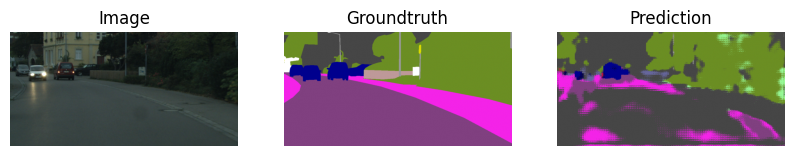

torch.Size([3, 512, 1024]) torch.Size([512, 1024])
img: torch.Size([3, 512, 1024])  target: torch.Size([512, 1024])
pred: torch.Size([5, 512, 1024])


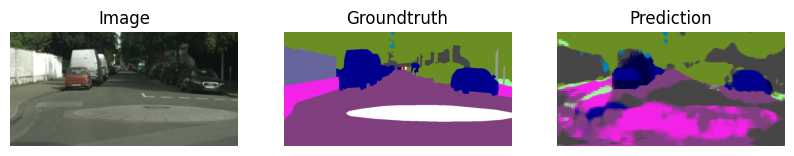

torch.Size([3, 512, 1024]) torch.Size([512, 1024])
img: torch.Size([3, 512, 1024])  target: torch.Size([512, 1024])
pred: torch.Size([5, 512, 1024])


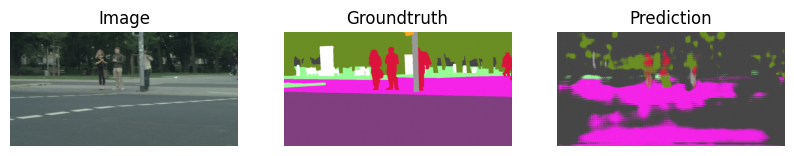

torch.Size([3, 512, 1024]) torch.Size([512, 1024])
img: torch.Size([3, 512, 1024])  target: torch.Size([512, 1024])
pred: torch.Size([5, 512, 1024])


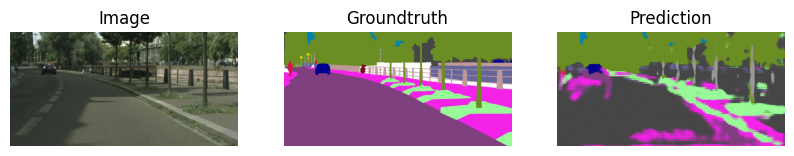

torch.Size([3, 512, 1024]) torch.Size([512, 1024])
img: torch.Size([3, 512, 1024])  target: torch.Size([512, 1024])
pred: torch.Size([5, 512, 1024])


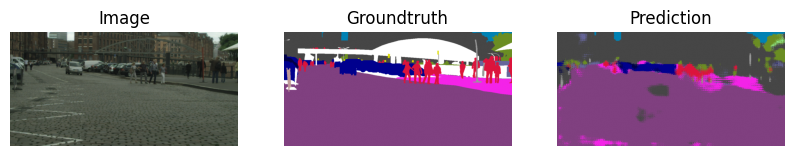

In [118]:
print("validation plot : ")
validation_plot(net=model, val_dataloader=val_dataloader, n_images=5)
torch.cuda.empty_cache()